In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [1]:
from configparser import ConfigParser


def config(filename="database.ini", section="postgresql"):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)

    # get section, default to postgresql
    db = {}

    # Checks to see if section (postgresql) parser exists
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]

    # Returns an error if a parameter is called that is not listed in the initialization file
    else:
        raise Exception(
            "Section {0} not found in the {1} file".format(section, filename)
        )

    return db

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
import numpy as np


def create_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

In [4]:
import numpy as np


def create_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

In [5]:
import os

# os.environ["CUDA_DEVICE_ORDER"] = "GPU"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17586449821391120183
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18335845216860784604
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2715222016
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 6813756094427460091
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:84:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1890195584723836371
physical_device_desc: "device: XLA_GPU device"
]


In [6]:
import psycopg2
import pandas as pd

# from conf_db import config

import os

import tensorflow as tf

from tensorflow import keras

import matplotlib.pyplot as plt

# from get_data import create_data

# Establish a connection to the database by creating a cursor object

# Obtain the configuration parameters
params = config("database.ini", "warden_rady")
# Connect to the PostgreSQL database
conn = psycopg2.connect(**params)
# Create a new cursor
cur = conn.cursor()

# A function that takes in a PostgreSQL query and outputs a pandas database
def create_pandas_table(sql_query, database=conn):
    table = pd.read_sql_query(sql_query, database)
    return table


# Utilize the create_pandas_table function to create a Pandas data frame
# Store the data as a variable
dataset1 = create_pandas_table(
    "SELECT time, value FROM history_int WHERE item_id = 30 ORDER BY time"
)
dataset1 = dataset1[232:]
print(len(dataset1))
print(dataset1)

# Close the cursor and connection to so the server can allocate
# bandwidth to other requests
cur.close()
conn.close()

5088
                          time  value
232  2017-12-10 16:00:00+00:00    236
233  2017-12-10 17:00:00+00:00    272
234  2017-12-10 18:00:00+00:00    125
235  2017-12-10 19:00:00+00:00    120
236  2017-12-10 20:00:00+00:00    116
...                        ...    ...
5315 2018-07-10 11:00:00+00:00    147
5316 2018-07-10 12:00:00+00:00    140
5317 2018-07-10 13:00:00+00:00    149
5318 2018-07-10 14:00:00+00:00    210
5319 2018-07-10 15:00:00+00:00    128

[5088 rows x 2 columns]


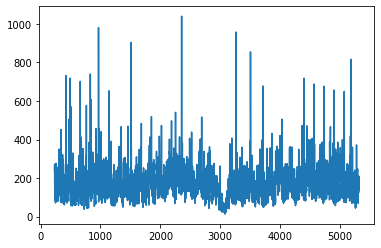

<IPython.core.display.Javascript object>

In [8]:
plt.plot(dataset1.value)
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
plt.rcParams["figure.figsize"] = [150, 50]
plt.show()

In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

<IPython.core.display.Javascript object>

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy

# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
# dataframe = read_csv("airline-passengers.csv", usecols=[1], engine="python")
dataframe = dataset1["value"].to_frame()
dataset = dataframe.values
dataset = dataset.astype("float32")
print(len(dataset))
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]
# reshape into X=t and Y=t+1
look_back = 500
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX)
print(trainY)

5088
[[[0.21637428 0.25146198 0.10818713 ... 0.02923977 0.03216374 0.03703704]]

 [[0.25146198 0.10818713 0.10331384 ... 0.03216374 0.03703704 0.07309941]]

 [[0.10818713 0.10331384 0.09941521 ... 0.03703704 0.07309941 0.04385965]]

 ...

 [[0.17836258 0.14132553 0.15594542 ... 0.07407407 0.09746589 0.13840157]]

 [[0.14132553 0.15594542 0.1276803  ... 0.09746589 0.13840157 0.11111111]]

 [[0.15594542 0.1276803  0.10038986 ... 0.13840157 0.11111111 0.09161793]]]
[0.07309941 0.04385965 0.08479532 ... 0.11111111 0.09161793 0.08674464]


<IPython.core.display.Javascript object>

In [11]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(100, activation="tanh"),
        #         tf.keras.layers.Dense(20, activation="tanh"),
        #         tf.keras.layers.Dense(15, activation="tanh"),
        tf.keras.layers.Dense(50, activation="tanh"),
        #         tf.keras.layers.Dense(5, activation="tanh"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"]
)

<IPython.core.display.Javascript object>

In [12]:
# for i in range(100):
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=2, shuffle=False)
#     model.reset_states()

Train on 2907 samples
Epoch 1/25
2907/2907 - 10s - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 2/25
2907/2907 - 9s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 3/25
2907/2907 - 9s - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 4/25
2907/2907 - 9s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 5/25
2907/2907 - 9s - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 6/25
2907/2907 - 9s - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 7/25
2907/2907 - 8s - loss: 0.0144 - mean_squared_error: 0.0144
Epoch 8/25
2907/2907 - 8s - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 9/25
2907/2907 - 9s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 10/25
2907/2907 - 8s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 11/25
2907/2907 - 9s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 12/25
2907/2907 - 9s - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 13/25
2907/2907 - 9s - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 14/25
2907/2907 - 9s - loss: 0.0081 - mean_squared_error:

<IPython.core.display.Javascript object>

In [1]:
# make predictions
trainPredict = model.predict(trainX)
trainPredict = trainPredict.reshape(-1, 1)
# a = []
# for i in trainPredict:
#     a.append(i[0][0])
# trainPredict = trainPredict = np.ndarray(a)
# trainPredict.reshape(-1, 1)
model.reset_states()
testPredict = model.predict(testX)
testPredict = testPredict.reshape(-1, 1)

NameError: name 'model' is not defined

In [15]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

<IPython.core.display.Javascript object>

In [16]:
trainY = trainY.reshape(-1, 1)
testY = testY.reshape(-1, 1)


# trainY = np.reshape(trainY, len(trainY))
print(trainY)
print(testY)

[[ 88.99999618]
 [ 59.        ]
 [100.99999618]
 ...
 [128.        ]
 [108.        ]
 [103.00000382]]
[[140.        ]
 [136.        ]
 [116.        ]
 ...
 [140.        ]
 [149.00000382]
 [209.99998471]]


<IPython.core.display.Javascript object>

In [17]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print("Test Score: %.2f RMSE" % (testScore))

# id 24
# Train Score: 1030.19 RMSE
# Test Score: 1250.47 RMSE

# id 30
# Train Score: 60.00 RMSE
# Test Score: 65.91 RMSE

Train Score: 294.53 RMSE
Test Score: 304.37 RMSE


<IPython.core.display.Javascript object>

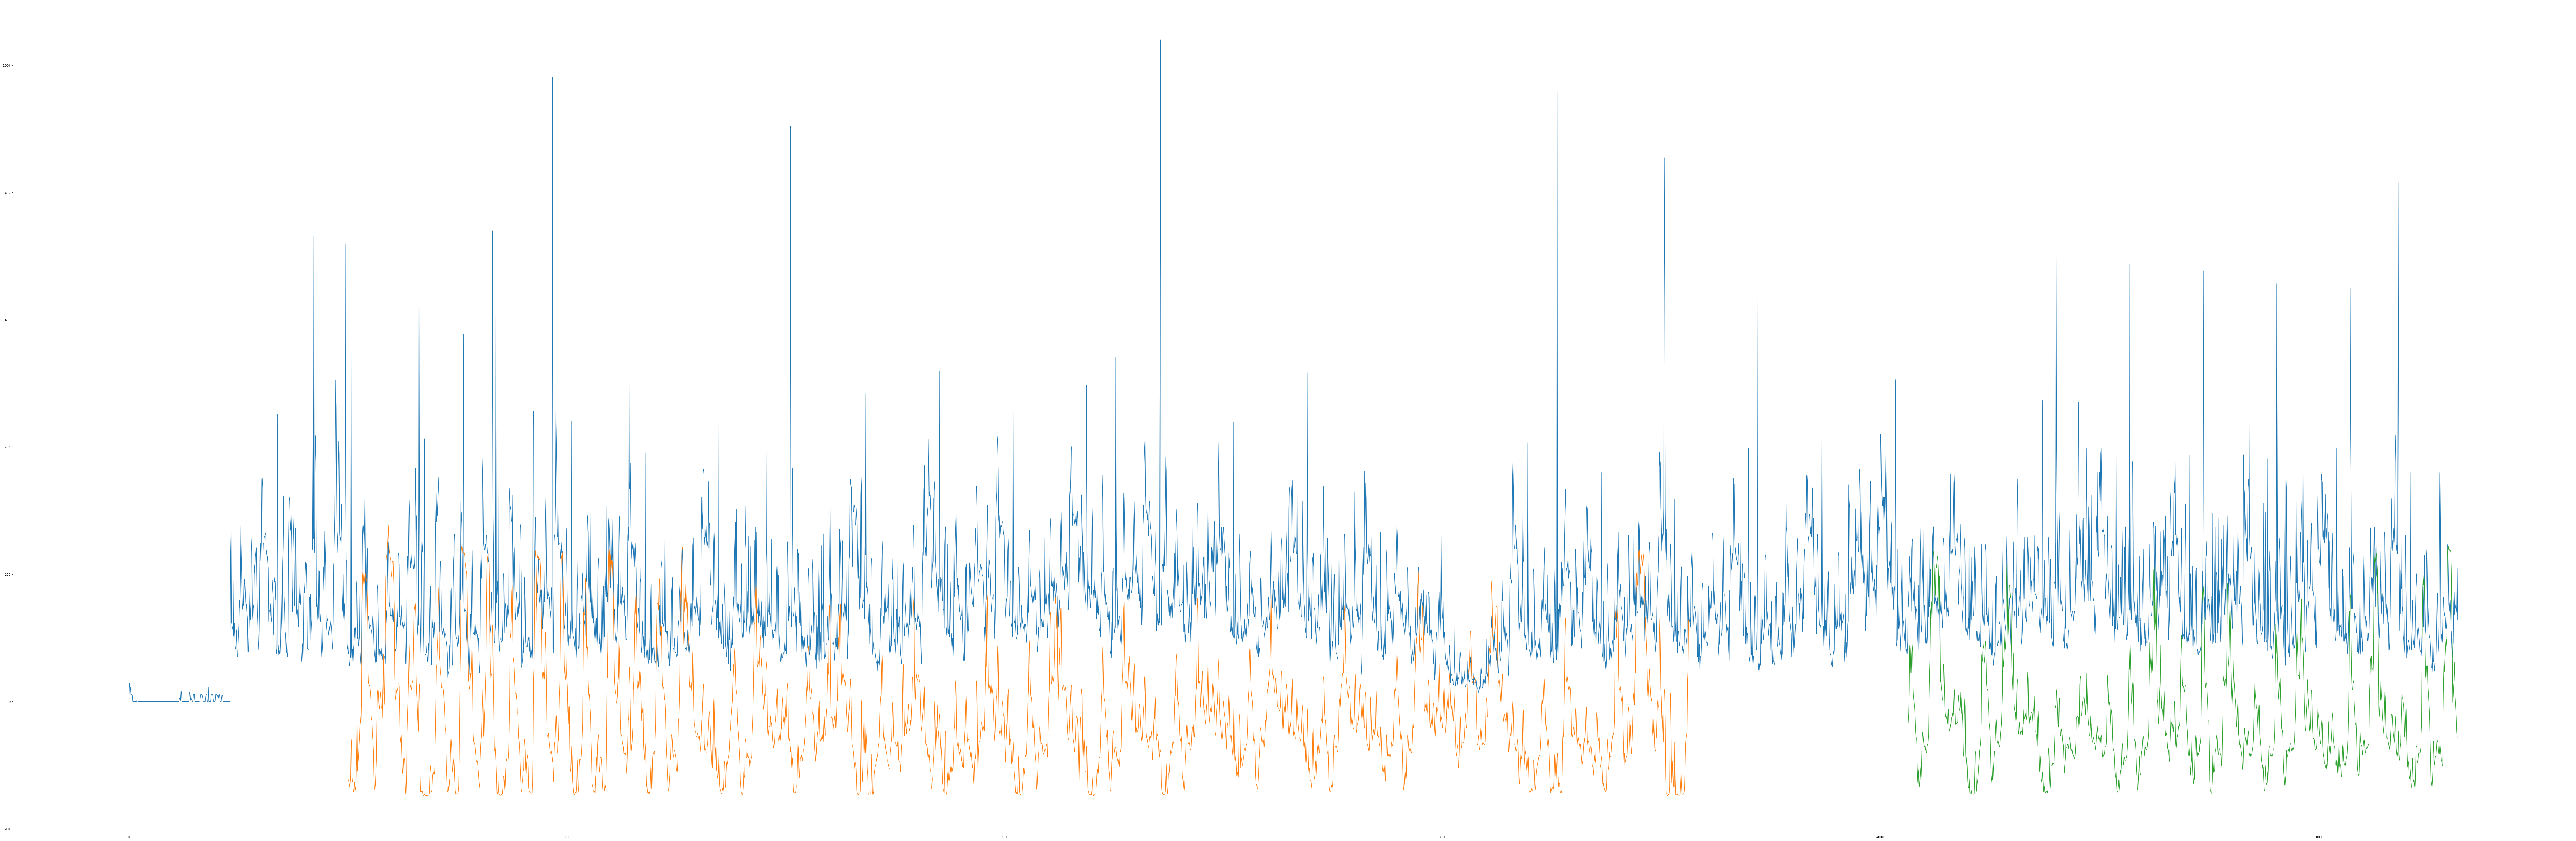

<IPython.core.display.Javascript object>

In [58]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : len(trainPredict) + look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(trainPredict) + (look_back * 2) + 1 : len(dataset) - 1, :
] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.rcParams["figure.figsize"] = [150, 50]
plt.show()

In [19]:
import plotly.graph_objects as go

x = np.arange(len(dataset))

dataset1 = scaler.inverse_transform(dataset)
merged_list = []

for l in dataset1:
    merged_list.append(int(l[0]))


fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=merged_list, mode="lines", name="povodne data",))
fig.add_trace(
    go.Scatter(
        x=x[look_back : len(trainPredict) + look_back],
        y=np.reshape(trainPredict, len(trainPredict)),
        mode="lines",
        name="treningova mnozina",
    )
)
fig.add_trace(
    go.Scatter(
        x=x[len(trainPredict) + (look_back * 2) + 1 : len(dataset) - 1],
        y=np.reshape(testPredict, len(testPredict)),
        mode="lines",
        name="testovacia mnozina",
    )
)

fig.show()

<IPython.core.display.Javascript object>